In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import unicodedata

#nltk data
nltk.download('punkt')
nltk.download('stopwords')

nltk.download('punkt_tab')

# for stem words, later
ps = PorterStemmer()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kristinalonge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kristinalonge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kristinalonge/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    #remove non-ASCII characters
    text = ''.join(char for char in text if ord(char) < 128)
    #remove special characters, digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #remove extra whitespace
    text = ' '.join(text.split())
    return text


In [3]:
def extract_info(text):
    if not isinstance(text, str):
        return {}
    
    info = {}
    
    # clean text
    cleaned_text = clean_text(text)
    
    #extract model/cas
    cas_match = re.search(r'Model No\s*(\S+)', cleaned_text)
    if cas_match:
        info['CAS'] = cas_match.group(1)
    
    #extract brand name
    brand_match = re.search(r'Brand Name\s*(.+?)(?:\n|$)', cleaned_text)
    if brand_match:
        info['Brand Name'] = brand_match.group(1).strip()
    
    #extract company
    company_match = re.search(r'Company\s*(.+?)(?:\n|$)', cleaned_text)
    if company_match:
        info['Company'] = company_match.group(1).strip()
    
    #extract contact person
    contact_match = re.search(r'Contact Person\s*(.+?)(?:\n|$)', cleaned_text)
    if contact_match:
        info['Contact Person'] = contact_match.group(1).strip()
    
    #extract prod. description
    desc_match = re.search(r'Product Description(.*?)Contact', cleaned_text, re.DOTALL)
    if desc_match:
        info['Product Description'] = desc_match.group(1).strip()
    
    return info


In [4]:
def process_substances(df):
    substances = df['Substance'].dropna().astype(str).str.lower().tolist()
    synonyms = df['Synonyms'].dropna().astype(str).str.split(';').explode().str.strip().str.lower().tolist()
    return set(substances + synonyms)


In [5]:
def preprocess_text(text, substance_names):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    stop_words.add('cas') #think more about this...
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in substance_names]
    return tokens


In [6]:
def find_key_phrases(text, substance_names, n=2):
    tokens = preprocess_text(text, substance_names)
    return list(nltk.ngrams(tokens, n))


In [7]:
#match [prod. description] substance names to fent_precursors

In [8]:
def analyze_data(df, substance_names):
    all_tokens = []
    all_phrases = []
    companies = set()
    cas_numbers = set()
    skipped_entries = 0
    
    for _, row in df.iterrows():
        if isinstance(row['Product Description'], str):
            info = extract_info(row['Product Description'])
            
            if 'Product Description' in info:
                tokens = preprocess_text(info['Product Description'], substance_names)
                all_tokens.extend(tokens)
                all_phrases.extend(find_key_phrases(info['Product Description'], substance_names))
            
            if 'Company' in info:
                companies.add(info['Company'])
            
            if 'CAS' in info:
                cas_numbers.add(info['CAS'])
        else:
            skipped_entries += 1
    
    token_freq = Counter(all_tokens)
    phrase_freq = Counter(all_phrases)
    
    return {
        'unique_companies': len(companies),
        'unique_cas_numbers': len(cas_numbers),
        'token_freq': token_freq,
        'phrase_freq': phrase_freq,
        'skipped_entries': skipped_entries,
        'top_20_words': token_freq.most_common(20),
        'top_20_phrases': phrase_freq.most_common(20)
    }


In [9]:
#store [prod description] substnaces in data table by company.

In [10]:
def create_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords={'cas'}).generate_from_frequencies(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Common Words and Phrases')
    plt.show()



In [11]:
#read Foreign Trade xls
foreign_trade_df = pd.read_excel('/Users/kristinalonge/Desktop/Files For NLP/Team 3/Foreign Trade Matched Data with CAS_prep.xlsx', 
                                 sheet_name='Foreign Trade Matched Data Pull')

#read Fentanyl Precursors xls
fentanyl_df = pd.read_excel('/Users/kristinalonge/Desktop/Files For NLP/Useful Info/Fentanyl_Precursors_All.xls')

#process substances & synonyms
def process_substances(df):
    substances = df['Substance'].str.lower().tolist()
    synonyms = df['Synonyms'].str.split(';').explode().str.strip().str.lower().tolist()
    return set(substances + synonyms)


substance_names = process_substances(fentanyl_df)


In [12]:
#analyze data
analysis_results = analyze_data(foreign_trade_df, substance_names)

Number of unique companies: 463
Number of unique CAS numbers: 115
Number of skipped entries: 670

Top 20 most common words:
bmk: 49526
pmk: 46085
products: 32982
oil: 31584
hcl: 30178
powder: 30117
ethyl: 29516
quality: 28168
acid: 24932
delivery: 21685
product: 20276
bromomethylpropiophenone: 19610
procaine: 17677
lidocaine: 17236
price: 16770
safe: 16323
us: 15644
bromophenylpentanone: 15340
tetracaine: 14374
benzocaine: 13897

Top 20 most common phrases:
bmk oil: 12302
pmk ethyl: 11137
pmk oil: 9141
glycidic acid: 7121
bmk powder: 6628
bmk glycidic: 6451
high quality: 5787
pharmaceutical intermediates: 5344
oil pmk: 5232
western union: 5169
customs clearance: 5054
boric acid: 4939
kg kg: 4920
procaine hcl: 4897
ethyl oxophenylbutanoate: 4778
oil bmk: 4507
raw materials: 4395
powder bmk: 4362
sodium salt: 4272
new bmk: 4174


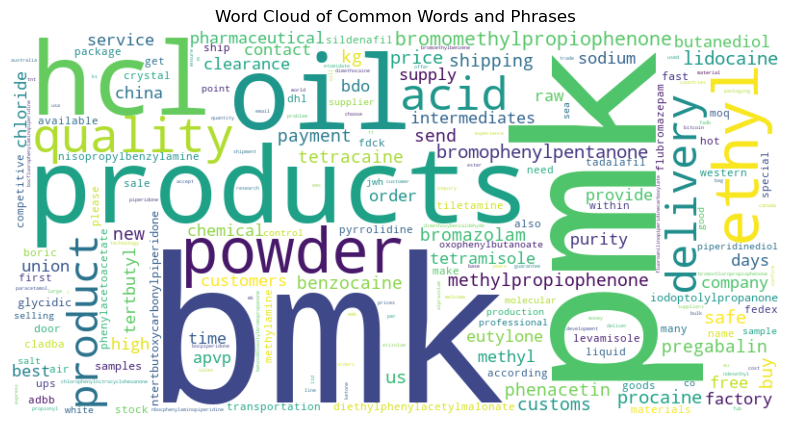

In [15]:
#print results
print(f"Number of unique companies: {analysis_results['unique_companies']}")
print(f"Number of unique CAS numbers: {analysis_results['unique_cas_numbers']}")
print(f"Number of skipped entries: {analysis_results['skipped_entries']}")

print("\nTop 20 most common words:")
for word, count in analysis_results['top_20_words']:
    print(f"{word}: {count}")

print("\nTop 20 most common phrases:")
for phrase, count in analysis_results['top_20_phrases']:
    print(f"{' '.join(phrase)}: {count}")

#word cloud
create_word_cloud(analysis_results['token_freq'])


In [ ]:
#filter out substances from words cloud, find more words/phrases

#df w/ extracted information
extracted_info = df['Product Description'].apply(extract_info)
extracted_df = pd.DataFrame(extracted_info.tolist())

#save to excel
extracted_df.to_excel('extracted_information.xlsx', index=False)
print("\nExtracted information saved to 'extracted_information.xlsx'")